<a href="https://colab.research.google.com/github/Momentum1ab/MomentumScreener/blob/main/RRG_MLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the benchmark index ticker (e.g., ^NSEI for Nifty 50): ^NSEI
Enter up to 10 tickers separated by commas (e.g., ^CNXFMCG,^CNXIT,GOLDBEES.NS): ^CNXFMCG,^CNXIT
Enter the period (e.g., 1y, 2y, 5y): 2y
Enter the window size for calculations (e.g., 12): 12
Enter the tail length for plotting (e.g., 5): 5


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


Tickers data shape: (105, 2)
Benchmark data shape: (105, 1)
Processing ticker: ^CNXFMCG
Shape of rs: (105, 106)
Shape of rsr: (0, 106)
Processing ticker: ^CNXIT
Shape of rs: (105, 106)
Shape of rsr: (0, 106)


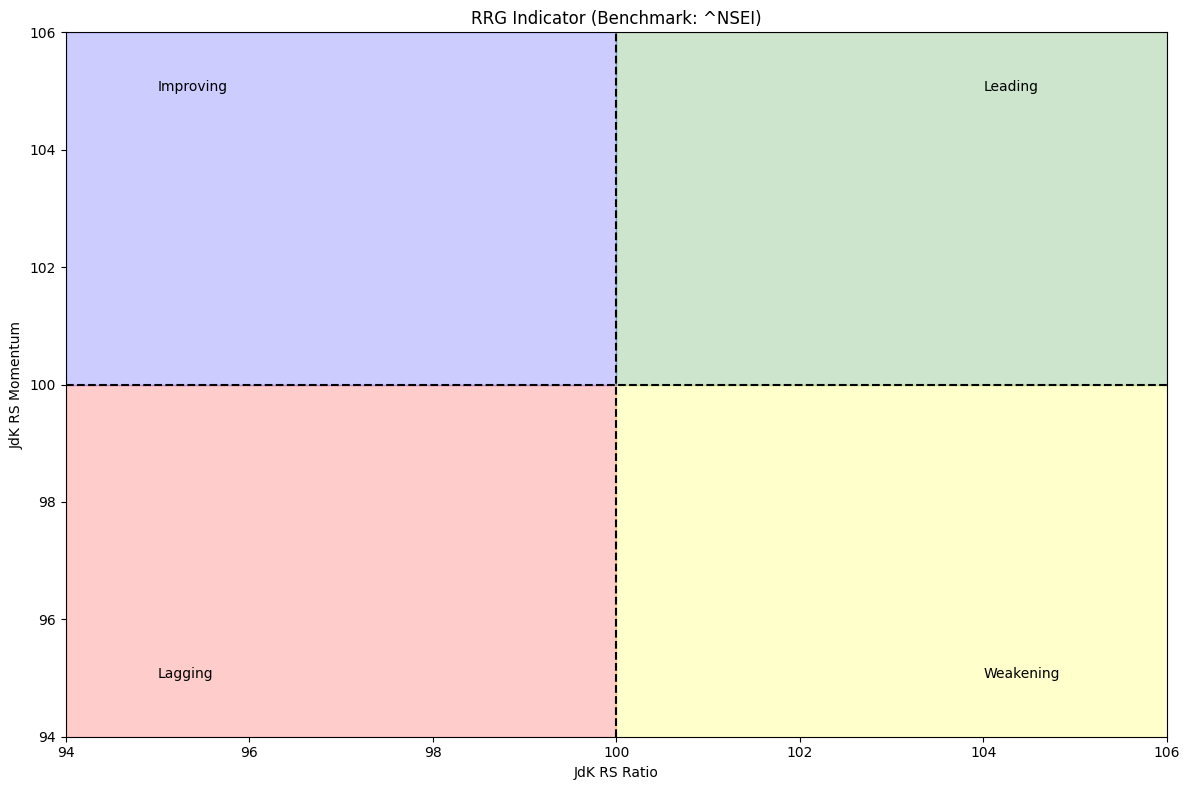

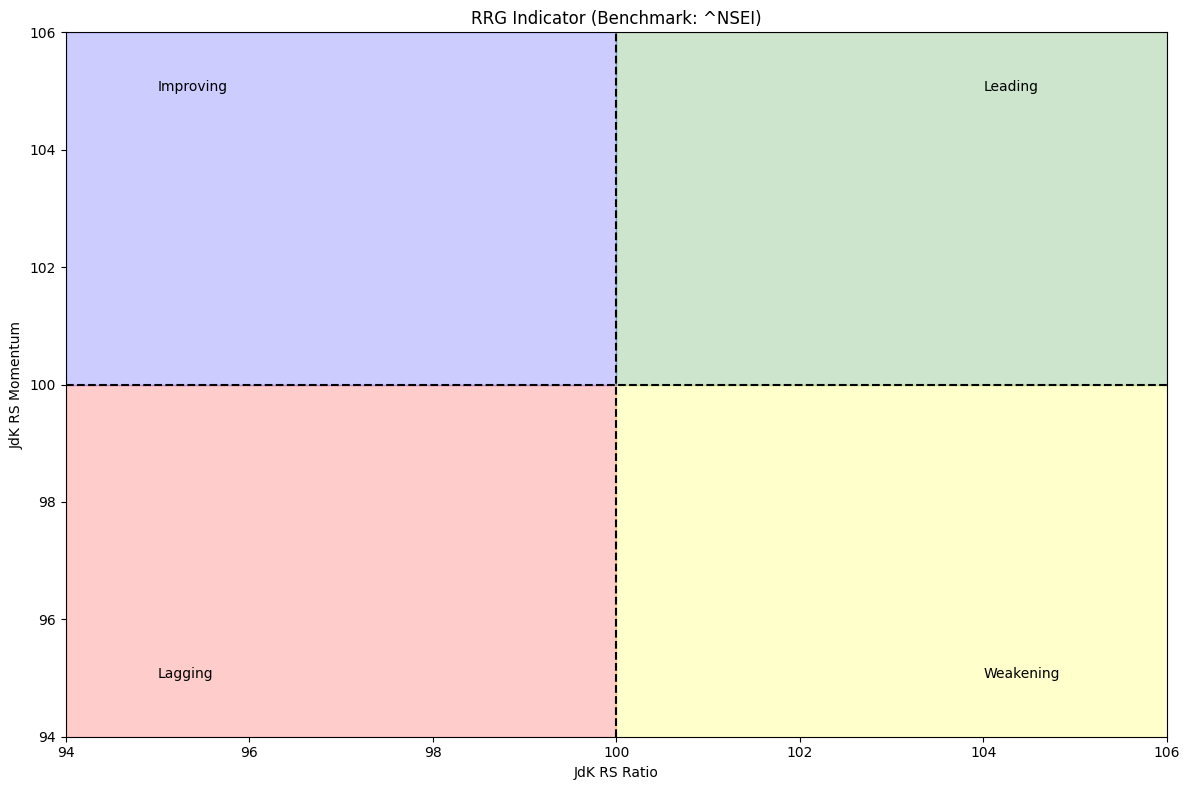

Ticker         Name                          Price     Change (%)Status    
---------------------------------------------------------------------------


IndexError: single positional indexer is out-of-bounds

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

class RRGPlotter:
    def __init__(self, benchmark, tickers, period='2y', window=12, tail=5):
        self.benchmark = benchmark
        self.tickers = tickers[:10]  # Limit to max 10 tickers
        self.period = period
        self.window = window
        self.tail = tail
        self.load_data()
        self.calculate_rrg()
        self.create_plot()

    def load_data(self):
        try:
            all_tickers = self.tickers + [self.benchmark]
            data = yf.download(all_tickers, period=self.period, interval="1wk")['Adj Close']

            # Remove tickers with no data
            valid_tickers = [ticker for ticker in all_tickers if ticker in data.columns]
            invalid_tickers = set(all_tickers) - set(valid_tickers)
            if invalid_tickers:
                print(f"Warning: No data found for tickers: {', '.join(invalid_tickers)}")

            self.tickers = [ticker for ticker in self.tickers if ticker in valid_tickers]

            # Ensure all data is timezone-naive
            data = self.make_tz_naive(data)

            self.benchmark_data = data[self.benchmark]
            self.tickers_data = data[self.tickers]

            # Double-check that all data is timezone-naive
            assert self.benchmark_data.index.tz is None, "Benchmark data is not timezone-naive"
            assert self.tickers_data.index.tz is None, "Tickers data is not timezone-naive"

        except Exception as e:
            print(f"Error loading data: {e}")
            raise

        print(f"Tickers data shape: {self.tickers_data.shape}")
        print(f"Benchmark data shape: {self.benchmark_data.shape}")

    @staticmethod
    def make_tz_naive(data):
        if isinstance(data, pd.DataFrame):
            return data.tz_localize(None)
        elif isinstance(data, pd.Series):
            return data.tz_localize(None)
        else:
            raise ValueError("Input must be a DataFrame or Series")

    def calculate_rrg(self):
        self.rs_tickers = []
        self.rsr_tickers = []
        self.rsr_roc_tickers = []
        self.rsm_tickers = []

        for ticker in self.tickers:
            try:
                ticker_data = self.make_tz_naive(self.tickers_data[ticker])
                benchmark_data = self.make_tz_naive(self.benchmark_data)

                rs = 100 * (ticker_data / benchmark_data)
                rsr = (100 + (rs - rs.rolling(window=self.window).mean()) / rs.rolling(window=self.window).std(ddof=0)).dropna()

                if not rsr.empty:
                    rsr_roc = 100 * ((rsr / rsr.shift(1)) - 1)
                    rsm = (101 + ((rsr_roc - rsr_roc.rolling(window=self.window).mean()) / rsr_roc.rolling(window=self.window).std(ddof=0))).dropna()

                    self.rs_tickers.append(rs)
                    self.rsr_tickers.append(rsr[rsr.index.isin(rsm.index)])
                    self.rsr_roc_tickers.append(rsr_roc)
                    self.rsm_tickers.append(rsm)
                else:
                    print(f"Warning: Empty DataFrame for ticker {ticker}")
                    self.rs_tickers.append(pd.Series())
                    self.rsr_tickers.append(pd.Series())
                    self.rsr_roc_tickers.append(pd.Series())
                    self.rsm_tickers.append(pd.Series())
            except Exception as e:
                print(f"Error processing ticker {ticker}: {e}")
                self.rs_tickers.append(pd.Series())
                self.rsr_tickers.append(pd.Series())
                self.rsr_roc_tickers.append(pd.Series())
                self.rsm_tickers.append(pd.Series())

        # Remove tickers with empty data
        valid_indices = [i for i, rsr in enumerate(self.rsr_tickers) if not rsr.empty]
        self.tickers = [self.tickers[i] for i in valid_indices]
        self.rs_tickers = [self.rs_tickers[i] for i in valid_indices]
        self.rsr_tickers = [self.rsr_tickers[i] for i in valid_indices]
        self.rsr_roc_tickers = [self.rsr_roc_tickers[i] for i in valid_indices]
        self.rsm_tickers = [self.rsm_tickers[i] for i in valid_indices]

    def create_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 8))
        self.ax.set_title(f'RRG Indicator (Benchmark: {self.benchmark})')
        self.ax.set_xlabel('JdK RS Ratio')
        self.ax.set_ylabel('JdK RS Momentum')

        self.ax.axhline(y=100, color='k', linestyle='--')
        self.ax.axvline(x=100, color='k', linestyle='--')

        self.ax.fill_between([94, 100], [94, 94], [100, 100], color='red', alpha=0.2)
        self.ax.fill_between([100, 106], [94, 94], [100, 100], color='yellow', alpha=0.2)
        self.ax.fill_between([100, 106], [100, 100], [106, 106], color='green', alpha=0.2)
        self.ax.fill_between([94, 100], [100, 100], [106, 106], color='blue', alpha=0.2)

        self.ax.text(95, 105, 'Improving', fontsize=10)
        self.ax.text(104, 105, 'Leading', fontsize=10)
        self.ax.text(104, 95, 'Weakening', fontsize=10)
        self.ax.text(95, 95, 'Lagging', fontsize=10)

        self.ax.set_xlim(94, 106)
        self.ax.set_ylim(94, 106)

        self.scatter_plots = []
        self.line_plots = []
        self.annotations = []

        for i, ticker in enumerate(self.tickers):
            color = self.get_color(self.rsr_tickers[i].iloc[-1], self.rsm_tickers[i].iloc[-1])
            scatter = self.ax.scatter(self.rsr_tickers[i].iloc[-1], self.rsm_tickers[i].iloc[-1], color=color, s=50)
            line, = self.ax.plot(self.rsr_tickers[i].tail(self.tail), self.rsm_tickers[i].tail(self.tail), color=color, alpha=0.5)
            annotation = self.ax.annotate(ticker, (self.rsr_tickers[i].iloc[-1], self.rsm_tickers[i].iloc[-1]), fontsize=8)

            self.scatter_plots.append(scatter)
            self.line_plots.append(line)
            self.annotations.append(annotation)

        plt.tight_layout()

    def animate(self, num_frames=60):
        def update(frame):
            for i, ticker in enumerate(self.tickers):
                end_idx = min(frame + 1, len(self.rsr_tickers[i]))
                color = self.get_color(self.rsr_tickers[i].iloc[end_idx-1], self.rsm_tickers[i].iloc[end_idx-1])

                self.scatter_plots[i].set_offsets(np.c_[self.rsr_tickers[i].iloc[end_idx-1], self.rsm_tickers[i].iloc[end_idx-1]])
                self.scatter_plots[i].set_color(color)

                self.line_plots[i].set_data(self.rsr_tickers[i].iloc[max(0, end_idx-self.tail):end_idx],
                                            self.rsm_tickers[i].iloc[max(0, end_idx-self.tail):end_idx])
                self.line_plots[i].set_color(color)

                self.annotations[i].set_position((self.rsr_tickers[i].iloc[end_idx-1], self.rsm_tickers[i].iloc[end_idx-1]))

            return self.scatter_plots + self.line_plots + self.annotations

        anim = FuncAnimation(self.fig, update, frames=num_frames, interval=100, blit=True)
        return HTML(anim.to_jshtml())

    @staticmethod
    def get_status(x, y):
        if x < 100 and y < 100:
            return 'lagging'
        elif x > 100 and y > 100:
            return 'leading'
        elif x < 100 and y > 100:
            return 'improving'
        elif x > 100 and y < 100:
            return 'weakening'

    @staticmethod
    def get_color(x, y):
        status = RRGPlotter.get_status(x, y)
        return {'lagging': 'red', 'leading': 'green', 'improving': 'blue', 'weakening': 'yellow'}[status]

    def display_info(self):
        print(f"\n{'Ticker':<15}{'Name':<30}{'Price':<10}{'Change (%)':<10}{'Status':<10}")
        print("-" * 75)
        for i, ticker in enumerate(self.tickers):
            try:
                info = yf.Ticker(ticker).info
                name = info.get('longName', 'N/A')[:30]
                price = round(self.tickers_data[ticker].iloc[-1], 2)
                chg = round((price - self.tickers_data[ticker].iloc[0]) / self.tickers_data[ticker].iloc[0] * 100, 2)
                status = self.get_status(self.rsr_tickers[i].iloc[-1], self.rsm_tickers[i].iloc[-1])
                print(f"{ticker:<15}{name:<30}{price:<10.2f}{chg:<10.2f}{status:<10}")
            except Exception as e:
                print(f"Error displaying info for {ticker}: {e}")

def get_user_input():
    benchmark = input("Enter the benchmark index ticker (e.g., ^NSEI for Nifty 50): ")
    tickers = input("Enter up to 10 tickers separated by commas (e.g., ^CNXFMCG,^CNXIT,GOLDBEES.NS): ").split(',')
    tickers = [ticker.strip() for ticker in tickers[:10]]  # Limit to max 10 tickers
    period = input("Enter the period (e.g., 1y, 2y, 5y): ")
    window = int(input("Enter the window size for calculations (e.g., 12): "))
    tail = int(input("Enter the tail length for plotting (e.g., 5): "))

    return benchmark, tickers, period, window, tail

def main():
    benchmark, tickers, period, window, tail = get_user_input()

    try:
        rrg_plotter = RRGPlotter(benchmark, tickers, period, window, tail)

        if not rrg_plotter.tickers:
            print("No valid tickers found. Please check your input and try again.")
            return

        # Display static plot
        rrg_plotter.create_plot()
        plt.show()

        # Display animated plot
        animation_html = rrg_plotter.animate()
        display(animation_html)

        # Print table with ticker information
        rrg_plotter.display_info()

    except yf.exceptions.YFInvalidPeriodError as e:
        print(f"Invalid period: {e}")
        print("Please try using a different period. Valid periods include: '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'")
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Error details:")
        import traceback
        traceback.print_exc()
        print("\nPlease check your input and try again.")

if __name__ == "__main__":
    main()